In [2]:
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
from ggCorrelations import ggTheoryCorrMat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# from pdg 2020
br_Z_hadr = 69.911e-2
br_W_hadr = 67.41e-2


## ATLAS `H>gamgam` STXS [ATLAS-CONF-2020-026](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2020-026/)

This contains a 27-bin STXS measurement, which should be implemented once a HEPdata entry with the correlations is available. For now, we implement the 5-bin signal strength measurement instead.

TB: This measurment is superseeded by arXiv:2207.00348; CERN-EP-2022-094 (see the implementation below)

In [3]:
# subMeasurements = {
#     "H_gamgam": {
#         "obs": [
#             1.02 - 0.11,
#             1.02,
#             1.02 + 0.11,
#         ],
#         "ref": [1, 1, 1],
#         "process": {"channels": [["H", "gamgam"]]},
#     },
#     "vbfH_gamgam": {
#         "obs": [
#             1.34 - 0.24,
#             1.34,
#             1.34 + 0.26,
#         ],
#         "ref": [1, 1, 1],
#         "process": {"channels": [["vbfH", "gamgam"]]},
#     },
#     "HW_gamgam": {
#         "obs": [
#             2.33 - 0.5,
#             2.33,
#             2.33 + 0.55,
#         ],
#         "ref": [1, 1, 1],
#         "process": {"channels": [["HW", "gamgam"]]},
#     },
#     "HZ_gamgam": {
#         "obs": [
#             -0.64 - 0.57,
#             -0.64,
#             -0.64 + 0.61,
#         ],
#         "ref": [1, 1, 1],
#         "process": {"channels": [["HZ", "gamgam"]]},
#     },
#     "Htt_gamgam": {
#         "obs": [
#             0.92 - 0.24,
#             0.92,
#             0.92 + 0.27,
#         ],
#         "ref": [1, 1, 1],
#         "process": {"channels": [[p, "gamgam"] for p in ["Htt", "Ht", "HtW"]]},
#     },
# }
# corrMat = pd.DataFrame(
#     index=subMeasurements.keys(), columns=subMeasurements.keys(), data=np.diag(5 * [1])
# )
# corrMat.loc["H_gamgam", "vbfH_gamgam"] = -0.14
# corrMat.loc["H_gamgam", "HW_gamgam"] = -0.02
# corrMat.loc["H_gamgam", "HZ_gamgam"] = -0.07
# corrMat.loc["H_gamgam", "Htt_gamgam"] = 0.07
# corrMat.loc["vbfH_gamgam", "HW_gamgam"] = 0.03
# corrMat.loc["vbfH_gamgam", "HZ_gamgam"] = -0.02
# corrMat.loc["vbfH_gamgam", "Htt_gamgam"] = 0.06
# corrMat.loc["HW_gamgam", "HZ_gamgam"] = -0.42
# corrMat.loc["HW_gamgam", "Htt_gamgam"] = -0.01
# corrMat.loc["HZ_gamgam", "Htt_gamgam"] = -0.03
# measFile = implementMeasurement(
#     1809953,
#     "Fig. 10 & 11",
#     subMeasurements,
#     prefix="gamgam_incl",
#     corrMatExp=corrMat,
#     referenceMass=125,
#     massResolution=2.5,
# )


Nothing to compare to, but this looks reasonable.

In [4]:
# kappaF = np.linspace(0.4, 2.6)
# kappaV = np.linspace(0.8, 1.2)

# fig, ax = validateMeasurementKappa(
#     HS.Measurement(measFile), kappaF, kappaV, r"$H\to\gamma\gamma$"
# )


## ATLAS `H>gamgam` STXS [CERN-EP-2022-094](https://cds.cern.ch/record/2814435)

Here now the implementation of the ATLAS H -> gamgam Run 2 result as an STXS measurement. The results are quite different since the data changed significantly between
the published result and the conf-note result ATLAS-CONF-2020-026. This is visible, for instance, comparing Fig. 10 of ATLAS-CONF-2020-026 against Fig. 9 of CERN-EP-2022-094.

In [5]:
dfs = readHEPDataCsv("https://www.hepdata.net/download/table/ins2104770/Figure%2028/1/csv")
dfref = dfs[0]
dfobs = dfs[1]

dfobs["STXS region"] = dfobs["Parameter"]
del dfobs["Parameter"]
dfobs.set_index("STXS region", inplace=True)

def regulariseBinName(name):
    table = {ord(c): None for c in ("$", "_", "{", "}", "^", "/")} | {
        ord(c): ord("_") for c in ("-", " ")
    }
    y = name.translate(table).replace(r"\rightarrow", "").replace(r"\geq", "")
    y = y.replace(r"\ell", "").replace(r"\nu", "v")
    return y
dfobs = dfobs.rename(index=regulariseBinName)

df = pd.DataFrame()
df["obs"] = 1e-3 * dfobs["Observed cross section times branching ratio [fb]"]
df["obs+"] = df["obs"] + 1e-3 * dfobs["Total +"]
df["obs-"] = df["obs"] + 1e-3 * dfobs["Total -"]
# For some reason gives NaNs if np.array() removed
df["ref"] = np.array(1e-3 * dfref["SM predicted cross section times branching ratio [fb]"])
df["ref+"] = df["ref"] + np.array(1e-3 * dfref["SM +"])
df["ref-"] = df["ref"] + np.array(1e-3 * dfref["SM -"])

dfcorr = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins2104770/Figure%2013/1/csv"
)[0]
corrmatExp = pd.concat(
    [
        v.droplevel(0).rename(columns={"Observed correlation": k})
        for k, v in dfcorr.set_index(["STXS region (x)", "STXS region (y)"])
        .groupby("STXS region (x)")
    ],
    axis=1,
)

# Rename bin names by hand because the datafile for the
# correlation matrix uses different names
names = dfcorr["STXS region (y)"].unique()
df['STXS region'] = names
df.set_index("STXS region", inplace=True)

bins = {
    name: {
        "ref": [r["ref-"], r["ref"], r["ref+"]],
        "obs": [r["obs-"], r["obs"], r["obs+"]],
    }
    for name, r in df.iterrows()
}

# from pdg 2020
br_Z_hadr = 69.911e-2
br_W_hadr = 67.41e-2
for name, dat in bins.items():
    if name.startswith("gg2H"):
        dat["process"] = {"channels": [["H", "gamgam"]]}
    elif name.startswith("qq2Hlnu"):
        dat["process"] = {"channels": [["HW", "gamgam"]]}
    elif name.startswith("Hll"):
        dat["process"] = {"channels": [["HZ", "gamgam"]]}
    elif name.startswith("ttH"):
        dat["process"] = {"channels": [["Htt", "gamgam"]]}
    elif name.startswith("tH"):
        dat["process"] = {"channels": [[p, "gamgam"] for p in ("Ht", "HtW")]}
    else:
        dat["process"] = {"channels": [["vbfH", "gamgam"]]}

corrmatTheo = ggTheoryCorrMat(
    {x: "0j" for x in corrmatExp.index if x.startswith("gg2H_0J")}
    | {
        "gg2H_1J_ptH_0_60": "1j_0_60",
        "gg2H_1J_ptH_60_120": "1j_60_120",
        "gg2H_1J_ptH_120_200": "1j_120_200",
        "gg2H_ge2J_mJJ_0_350_ptH_0_120": ">=2j_0_60", # pT for 2J does not fit exactly
        "gg2H_ge2J_mJJ_0_350_ptH_120_200": ">=2j_60_120",
        "gg2H_ge2J_mJJ_gt350_ptH_0_200": ">=2j_120_200",
    },
    corrmatExp,
)

measFile = implementMeasurement(
    "2104770",
    "https://www.hepdata.net/download/table/ins2104770/Figure%2028/1/csv, https://www.hepdata.net/download/table/ins2104770/Figure%2013/1/csv, http://dgillber.web.cern.ch/dgillber/ggF_uncertainty_2017/corr2017.pdf",
    bins,
    prefix="gamgam_STXS",
    corrMatExp=corrmatExp,
    corrMatTheo=corrmatTheo,
    referenceMass=125.09,
    massResolution=2.5,
)

Looks good. Saving this to gamgam_STXS_LHC13_ATLAS_139.json


Verification plot comaring to Fig. of 23 of 2207.00348

(<Figure size 1100x400 with 4 Axes>,
 <AxesSubplot: title={'center': 'no THU correlations'}, xlabel='$\\kappa_V$', ylabel='$\\kappa_F$'>)

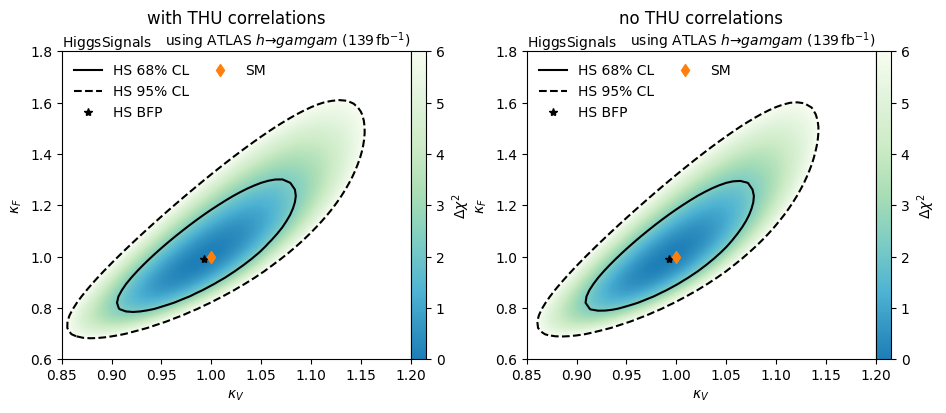

In [6]:
description = r"$h\to gamgam$"

kappaV = np.linspace(0.85, 1.2)
kappaF = np.linspace(0.6, 1.8)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4))

axs[0].set_title("with THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(measFile),
    kappaF,
    kappaV,
    description,
    fig=fig,
    ax=axs[0],
)

axs[1].set_title("no THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(
        measFile, HS.MeasurementOptions(whichCorrelations="experimentalOnly")
    ),
    kappaF,
    kappaV,
    description,
    fig=fig,
    ax=axs[1],
)

## CMS `H>gamgam` STXS 137fb-1 [2103.06956](http://arxiv.org/abs/2103.06956)

Use the maximal merging scheme STXS 1.2 results (the minimal merging scheme has some mixed VBF/ggH bins that would require some extra work).

In [4]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1851456/STXS%20stage%201.2%20maximal%20merging%20scheme/2/csv"
)


def regulariseBinName(name):
    table = {ord(c): None for c in ("$", "_", "{", "}", "^")} | {
        ord(c): ord("_") for c in ("-", " ")
    }
    return name.translate(table).replace("\geq", "")


df = 1e-3 * pd.concat(
    [df.set_index("STXS region").rename(index=regulariseBinName) for df in dfs[:2]],
    axis=1,
).rename(
    columns={
        "SM predicted cross section times branching ratio [fb]": "ref",
        "Theory +": "ref+",
        "Theory -": "ref-",
        "Observed cross section times branching ratio [fb]": "obs",
        "Total +": "obs+",
        "Total -": "obs-",
    },
)
df["ref+"] += df["ref"]
df["ref-"] += df["ref"]
df["obs+"] += df["obs"]
df["obs-"] += df["obs"]

# define the bins
bins = {
    name: {
        "ref": [r["ref-"], r["ref"], r["ref+"]],
        "obs": [r["obs-"], r["obs"], r["obs+"]],
    }
    for name, r in df.iterrows()
}

for name, dat in bins.items():
    if name.startswith("ggH"):
        dat["process"] = {"channels": [["H", "gamgam"]]}
    elif name.startswith("WH"):
        dat["process"] = {"channels": [["HW", "gamgam"]]}
    elif name.startswith("ZH"):
        dat["process"] = {"channels": [["HZ", "gamgam"]]}
    elif name == "qqH_VH_like":
        dat["process"] = {"channels": [["HZ", "gamgam"], ["HW", "gamgam"]]}
        dat["channelWeights"] = [br_Z_hadr, br_W_hadr]
    elif name == "ttH":
        dat["process"] = {"channels": [["Htt", "gamgam"]]}
    elif name == "tH":
        dat["process"] = {"channels": [[p, "gamgam"] for p in ("Ht", "HtW")]}
    else:
        dat["process"] = {"channels": [["vbfH", "gamgam"]]}

dfcorr = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1851456/Correlations%3A%20STXS%20stage%201.2%20maximal%20merging%20scheme/2/csv"
)[0]
corrmatExp = pd.concat(
    [
        v.droplevel(0).rename(columns={"Observed correlation": k})
        for k, v in dfcorr.set_index(["STXS region (x)", "STXS region (y)"])
        .rename(index=regulariseBinName)
        .groupby("STXS region (x)")
    ],
    axis=1,
)

corrmatTheo = ggTheoryCorrMat(
    {x: "0j" for x in corrmatExp.index if x.startswith("ggH_0J")}
    | {
        "ggH_1J_low_pTH": "1j_0_60",
        "ggH_1J_med_pTH": "1j_60_120",
        "ggH_1J_high_pTH": "1j_120_200",
        "ggH_2J_low_pTH": ">=2j_0_60",
        "ggH_2J_med_pTH": ">=2j_60_120",
        "ggH_2J_high_pTH": ">=2j_120_200",
        "ggH_BSM": ">=1j_>200",
    },
    corrmatExp,
)

measFile = implementMeasurement(
    "2103.06956",
    "https://doi.org/10.17182/hepdata.102459.v2/t4, https://doi.org/10.17182/hepdata.102459.v2/t5, http://dgillber.web.cern.ch/dgillber/ggF_uncertainty_2017/corr2017.pdf",
    bins,
    prefix="gamgam_STXS",
    corrMatExp=corrmatExp,
    corrMatTheo=corrmatTheo,
    referenceMass=125.38,
    massResolution=2.5,
)


Looks good. Saving this to gamgam_STXS_LHC13_CMS_137.json


Compare to Fig. 22 (top), the no THU correlations plot matches that one really well except for the BFP, but the difference between the deepest point in the two regions is tiny.

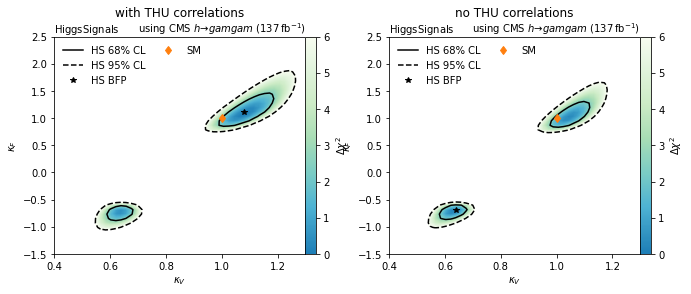

In [5]:
description = r"$h\to gamgam$"

kappaF = np.linspace(-1.5, 2.5)
kappaV = np.linspace(0.4, 1.3)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4))

axs[0].set_title("with THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(measFile),
    kappaF,
    kappaV,
    description,
    fig=fig,
    ax=axs[0],
)

axs[1].set_title("no THU correlations", pad=20)
validateMeasurementKappa(
    HS.Measurement(
        measFile, HS.MeasurementOptions(whichCorrelations="experimentalOnly")
    ),
    kappaF,
    kappaV,
    description,
    fig=fig,
    ax=axs[1],
)
plt.show()
